In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Downloading the dataset form drive 

In [16]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
download = drive.CreateFile({'id':'1DivrODizxQiB6eKbbaNOU9iq-Ol8iNFG'})
download.GetContentFile("CNN image dataset (Tomato).zip")

In [5]:
import zipfile
import io
data = zipfile.ZipFile('CNN image dataset (Tomato).zip','r')
data.extractall()

In [6]:
train_dir = '/content/tomato/train'
validation_dir = '/content/tomato/val'

Dividing the data into train, test and validation 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = '/content/tomato/train'  
test_dir = '/content/tomato/test'  

test_percentage = 0.2

for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)  
    class_test_dir = os.path.join(test_dir, class_name)    

    os.makedirs(class_test_dir, exist_ok=True)

    images = os.listdir(class_train_dir)

    num_images_to_move = int(len(images) * test_percentage)

    images_to_move = images[:num_images_to_move]

    for img in images_to_move:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_test_dir, img))

def count_images(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        count += len(files)
    return count

print(f"Train images: {count_images(train_dir)}")
print(f"Test images: {count_images(test_dir)}")

Train images: 8000
Test images: 2000


In [15]:
def count_images(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        count += len(files)
    return count

print(f"Train images: {count_images(train_dir)}")
print(f"Validate images: {count_images(validation_dir)}")
print(f'Test images: {count_images(test_dir)}')

Train images: 8000
Validate images: 1000
Test images: 2000


In [ ]:
import os

train_dir = '/content/tomato/train'     
test_dir = '/content/tomato/test'       

def count_images_in_classes(folder):
    print(f"Folder: {folder}")
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if os.path.isdir(class_dir):  
            num_images = len(os.listdir(class_dir))
            print(f"  Class: {class_name} - Images: {num_images}")
    print()

count_images_in_classes(train_dir)
count_images_in_classes(validation_dir)
count_images_in_classes(test_dir)

Folder: /content/tomato/train
  Class: Tomato___Leaf_Mold - Images: 800
  Class: Tomato___Late_blight - Images: 800
  Class: Tomato___Tomato_mosaic_virus - Images: 800
  Class: Tomato___Bacterial_spot - Images: 800
  Class: Tomato___healthy - Images: 800
  Class: Tomato___Septoria_leaf_spot - Images: 800
  Class: Tomato___Spider_mites Two-spotted_spider_mite - Images: 800
  Class: Tomato___Early_blight - Images: 800
  Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus - Images: 800
  Class: Tomato___Target_Spot - Images: 800

Folder: /content/tomato/val
  Class: Tomato___Leaf_Mold - Images: 100
  Class: Tomato___Late_blight - Images: 100
  Class: Tomato___Tomato_mosaic_virus - Images: 100
  Class: Tomato___Bacterial_spot - Images: 100
  Class: Tomato___healthy - Images: 100
  Class: Tomato___Septoria_leaf_spot - Images: 100
  Class: Tomato___Spider_mites Two-spotted_spider_mite - Images: 100
  Class: Tomato___Early_blight - Images: 100
  Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus - Image

The model from tensor flow and also my tries to imporve it even more!

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os

batch_size = 64
image_size = 150

train_dir = '/content/tomato/train'  
validation_dir = '/content/tomato/val'  
test_dir = '/content/tomato/test'  

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   height_shift_range=0.3,
                                   width_shift_range=0.3,
                                   shear_range=0.3,
                                   horizontal_flip=True,
                                   zoom_range=0.3,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

conv_base.trainable = False  # Freeze the base model

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(60))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(10))
model2.add(layers.Activation('softmax'))

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', monitor='val_loss', save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

model2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpointer, early]
)





Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 556ms/step - accuracy: 0.1261 - loss: 2.3659 - val_accuracy: 0.2802 - val_loss: 2.1650
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 529ms/step - accuracy: 0.2084 - loss: 2.1837 - val_accuracy: 0.4521 - val_loss: 1.9661


change shear and height

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os

batch_size = 64
image_size = 150

train_dir = '/content/tomato/train'  
validation_dir = '/content/tomato/val'  
test_dir = '/content/tomato/test'  

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

conv_base.trainable = False  #

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(60))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(10))
model2.add(layers.Activation('softmax'))

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', monitor='val_loss', save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpointer, early]
)





Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 510ms/step - accuracy: 0.1518 - loss: 2.3220 - val_accuracy: 0.3594 - val_loss: 1.9345
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.2323 - loss: 2.0646 - val_accuracy: 0.4490 - val_loss: 1.6981


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os

batch_size = 64
image_size = 150

train_dir = '/content/tomato/train'  
validation_dir = '/content/tomato/val'  
test_dir = '/content/tomato/test' 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

conv_base.trainable = False  

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(60))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(10))
model2.add(layers.Activation('softmax'))

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', monitor='val_loss', save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpointer, early]
)





Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 509ms/step - accuracy: 0.1402 - loss: 2.3202 - val_accuracy: 0.3865 - val_loss: 1.8350
Epoch 2/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.2524 - loss: 1.9816 - val_accuracy: 0.5500 - val_loss: 1.6065
Epoch 3/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 498ms/step - accuracy: 0.3374 - loss: 1.8255 - val_accuracy: 0.5729 - val_loss: 1.5046
Epoch 4/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 980ms/step - accuracy: 0.3816 - loss: 1.7274 - val_accuracy: 0.5896 - val_loss: 1.3395
Epoch 5/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.4116 - loss: 1.6549 - val_accuracy: 0.6302 - val_loss: 1.2925
Epoch 6/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 985ms/step - accuracy: 0.4231 - loss: 1.6115 - val_accuracy: 0.6417 - val_loss: 1.2055
Epoch 7/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 500ms/step - accuracy: 0.4473 - loss: 1.5560 - val_accuracy: 0.6490 - val_loss: 1.1695


dropout decrease

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os

batch_size = 64
image_size = 150

train_dir = '/content/tomato/train'
validation_dir = '/content/tomato/val'
test_dir = '/content/tomato/test'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Updated path
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

conv_base.trainable = False  

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(60))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(10))
model2.add(layers.Activation('softmax'))


checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', monitor='val_loss', save_best_only=True)


early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpointer, early]
)





Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 499ms/step - accuracy: 0.2372 - loss: 2.1488 - val_accuracy: 0.6448 - val_loss: 1.2059
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.5144 - loss: 1.3868 - val_accuracy: 0.6990 - val_loss: 0.9494
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 970ms/step - accuracy: 0.5969 - loss: 1.1689 - val_accuracy: 0.7490 - val_loss: 0.7951
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 656ms/step - accuracy: 0.6419 - loss: 1.0614 - val_accuracy: 0.7417 - val_loss: 0.7673
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 656ms/step - accuracy: 0.6716 - loss: 0.9692 - val_accuracy: 0.7510 - val_loss: 0.7324
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 656ms/step - accuracy: 0.6725 - loss: 0.9379 - val_accuracy: 0.7531 - val_loss: 0.7019
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - accuracy: 0.6996 - loss: 0.8816 - val_accuracy: 0.7760 - val_loss: 0.6891
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 653ms/step - accuracy: 0.6967 - loss

Trying fine-tuning for better accuracy 

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras import optimizers

In [24]:
for layer in conv_base.layers[:-1]:
  layer.trainable = False

model2.compile(optimizer=optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
history=model2.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=8,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//train_generator.batch_size,
                    verbose=1,
                    callbacks=[checkpointer,early])

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 485ms/step - accuracy: 0.7686 - loss: 0.6737 - val_accuracy: 0.8198 - val_loss: 0.5543
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 483ms/step - accuracy: 0.7776 - loss: 0.6671 - val_accuracy: 0.8219 - val_loss: 0.5466
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 654ms/step - accuracy: 0.7829 - loss: 0.6319 - val_accuracy: 0.8146 - val_loss: 0.5481
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - accuracy: 0.7864 - loss: 0.6387 - val_accuracy: 0.8146 - val_loss: 0.5504
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.7818 - loss: 0.6498 - val_accuracy: 0.8156 - val_loss: 0.5492
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 658ms/step - accuracy: 0.7834 - loss: 0.6589 - val_accuracy: 0.8115 - val_loss: 0.5420
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 656ms/step - accuracy: 0.7923 - loss: 0.6267 - val_accuracy: 0.8104 - val_loss: 0.5517
Epoch 7: early stopping


In [28]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=64,
    class_mode='categorical'
)
test_loss, test_acc = model2.evaluate(test_generator,steps=test_generator.samples//test_generator.batch_size)
print('test acc:',test_acc)
print('test loss:',test_loss)

Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.8564 - loss: 0.4550
test acc: 0.8563507795333862
test loss: 0.43425771594047546


Asking chatgpt to generate a external image to test it on the model

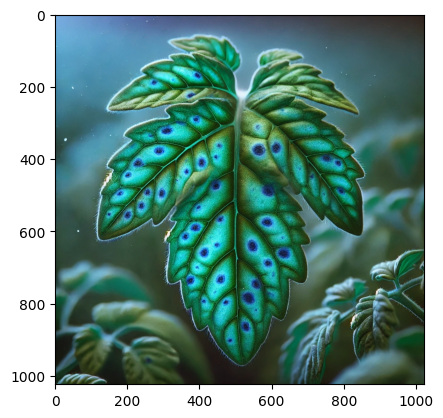

In [32]:
import matplotlib.pyplot as plt
import cv2
image_visual = cv2.imread(image_path)

plt.imshow(image_visual)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_path = '/content/tomato_leaf.jpg'  
image = load_img(image_path, target_size=(150, 150))  
image_array = img_to_array(image) / 255.0  
image_array = np.expand_dims(image_array, axis=0)  

predictions = model2.predict(image_array)
predicted_class = np.argmax(predictions)

print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 7


In [ ]:
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  
print(f"Class 7 corresponds to: {class_labels[7]}")


Class 7 corresponds to: Tomato___Tomato_Yellow_Leaf_Curl_Virus


And it was correct!